# Fit of outage model

We assume that outage starts at a certain point, then there is a constant high plateau of outage and then a linear decline. This notebook uses different ways to estimate the model parameters by doing the following steps in the given order:

- Start of outage: The largest increase of outage within one hour
- Length of outage: find the first occurrence where temperature is above 0°C, but at least MIN_OUTAGE_LENGTH_H after start
- Outage capacity: find the area preserving magnitude of outage between start of outage and start of outage + length of outage, i.e. the outage capacity which has the same area as the data reported by ERCOT.
- Assume the first data point as normal outage before the temperature dependent outage.
- Assume the average of the last 10 data points as normal outage after the temperature dependent outage.
- Use least square fit to find the length of a linear recovery period. A brute force algorithm is used, because the data is very noisy and other optimization algorithms fail or it cannot be trusted on them. The parameter space is quite small, so brute forcing is easy to do anyway.

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scipy.optimize import brute

In [3]:
import sys
sys.path.append('./..')

from scripts.refuelplot import *

In [4]:
setup()
sns.set_style("white")

In [5]:
DATA_DIR = Path().cwd().parent / 'data'
INTERIM_DIR = DATA_DIR / 'interim'
OUTAGES_DIR = INTERIM_DIR / 'outages'
FIG_RAW_DIR = DATA_DIR / 'figures' / 'raw_data'

In [6]:
matplotlib.rcParams["figure.figsize"] = (11, 8)

In [7]:
# Assumed threshold temperature for start of recovery period
RECOVERY_TEMPERATURE_DEGC = 0

# all fit parameters are non-negative and below 200h
MAX_DECLINE_LENGTH = 200

# Minimum number of outage assumed
MIN_OUTAGE_LENGTH_H = 10

# Enable plot of derivative of outage
PLOT_CHANGE_IN_OUTAGE = False

# Enable / disable export figures to PDF files
EXPORT_PLOTS_TO_PDF = True

# Filter size window for filtering change of outage
AVERAGING_WINDOW_SIZE = 0

END_DATE = '2021-02-25'

In [8]:
data = pd.read_csv(OUTAGES_DIR / 'outages_reduction.csv', parse_dates=['time'])
data = data.set_index('time')

In [9]:
data_north = pd.read_csv(OUTAGES_DIR / 'outages_reductionNorth.csv', parse_dates=['time'])
data_north = data_north.set_index('time')

In [10]:
data_south = pd.read_csv(OUTAGES_DIR / 'outages_reductionSouth.csv', parse_dates=['time'])
data_south = data_south.set_index('time')

In [11]:
# select relevant time range...
data = data[:END_DATE]
data_south = data_south[:END_DATE]
data_north = data_north[:END_DATE]

In [12]:
outage_function_parameters_all = pd.DataFrame(columns=[
    'generator_type',
    'outage_temperature_threshold',
    'recovery_temperature_threshold',
    'min_outage_length_h',
    'outage_capacity',
    'recovery_length',
])
outage_function_parameters_all.index.name = 'index'

In [13]:
def outage_model(times, decline_length, outage_start, outage_length, outage_capacity,
                 normal_outage_capacity_begin, normal_outage_capacity_end):
    """Models a constant outage beginning with `outage_start`, lasting for `outage_length` and
    then decinling for `decline_length`. Unit is assumed to be number of hours since a certain point in time,
    but not really important.
    The parameters `outage_capacity`, `normal_outage_capacity_begin`, `normal_outage_capacity_end` define the
    height of the three plateaus during outage, before and aftwards.

    `times` is an array-like object of values on the x-axis. Not tested with datetime objects, better use 
    number of hours.
    """
    outage_decline = outage_start + outage_length
    outage_end = outage_decline + decline_length

    def decline(times):
        """This part models a straight line, the decline during the recovery period."""
        if outage_end <= outage_decline:
            # avoid divison by zero by some arbitrary dummy value
            return 0 * times
        k = (normal_outage_capacity_end - outage_capacity) / (outage_end - outage_decline)
        d = normal_outage_capacity_end - k * outage_end
        return k * times + d

    y_data = np.piecewise(
        times,
        (
            times < outage_decline,
            times < outage_start,
            times > outage_end,
        ),
        [   
            outage_capacity,
            normal_outage_capacity_begin,
            normal_outage_capacity_end,
            decline,
        ]
    )

    # weird things are happening if params are of type int with curve_fit()
    # explicit type cast seems to help, but not sure why

    return y_data.astype(np.float64)

In [14]:
def fit_to_model(times, y_data, temperature):
    """Fits outage_model() to y_data. Uses a brute force fit, because not even Powell works in a stable way
    for coal when done with multiple parameters and with just one parameter brute forcing is very fast anyway."""

    def sum_squared_error(params, *args):
        # workaround because brute() searches also outside of the ranges, no hard bounds supported
        if np.any(params < 0):
            return np.inf

        return np.mean((outage_model(np.array(times), *params, *args) - y_data.values)**2)
    
    if AVERAGING_WINDOW_SIZE:
        y_data_change = y_data.rolling(AVERAGING_WINDOW_SIZE).mean().diff()
    else:
        y_data_change = y_data.diff()

    # Outage starts at the largest raise in out capacity within one hour. This is not
    # garantueed to work with noisy data, but it works in our three cases, so we can use it.
    outage_start = y_data_change.argmax()
    
    # Reovery starts as soon as temperature is above RECOVERY_TEMPERATURE_DEGC, after
    # MIN_OUTAGE_LENGTH_H hours of outage.
    outage_length = np.where(temperature[outage_start + MIN_OUTAGE_LENGTH_H:] > RECOVERY_TEMPERATURE_DEGC)[0][0]
    outage_length += MIN_OUTAGE_LENGTH_H
    
    outage_decline = outage_start + outage_length

    if outage_length <= 0:
        raise ValueError(f"invalid value for outage_length encountered: {outage_length}")

    # FIXME off-by-one error for recovery_begin? should this be included or not?
    outage_capacity = np.trapz(y_data.values[outage_start:outage_decline+1]) / outage_length

    normal_outage_capacity_begin = y_data.values[0]
    normal_outage_capacity_end = y_data.values[-10:].mean()

    args = outage_start, outage_length, outage_capacity, normal_outage_capacity_begin, normal_outage_capacity_end

    ranges = [(0, MAX_DECLINE_LENGTH)]

    params_optimal = brute(sum_squared_error, ranges, args=args, Ns=MAX_DECLINE_LENGTH + 1)

    decline_length, = params_optimal

    outage_end = outage_decline + decline_length
    k = (normal_outage_capacity_end - outage_capacity) / (outage_end - outage_decline)

    all_params = *params_optimal, *args

    # could use also return value of brute(), but does not matter
    error = sum_squared_error(params_optimal, *args)
    
    outage_function_parameters = {
        'outage_temperature_threshold': temperature[outage_start],
        'recovery_temperature_threshold': RECOVERY_TEMPERATURE_DEGC,
        'min_outage_length_h': MIN_OUTAGE_LENGTH_H,
        'outage_capacity': outage_capacity,
        'recovery_length': decline_length,
    }
    
    return k, error, all_params, outage_function_parameters

In [18]:
def plot_result(times, temperature, y_data, result):
    k, error, all_params, outage_function_parameters = result

    (decline_length, outage_start, outage_length, outage_capacity,
                normal_outage_capacity_begin, normal_outage_capacity_end) = all_params
    print("Fit results:")
    print(f"Recovery rate: k = {k}")
    print(f"Outage start: {y_data.index[0]} + {outage_start}h")
    print(f"Outage length: {outage_length}h")
    print(f"Recovery length: {decline_length}h")
    print(f"Outage capacity: {outage_capacity} GW")
    print(f"Outage capacity before: {normal_outage_capacity_begin} GW")
    print(f"Outage capacity after: {normal_outage_capacity_end} GW")
    
    fig, axes = plt.subplots(3 if PLOT_CHANGE_IN_OUTAGE else 2, sharex=True)
    if PLOT_CHANGE_IN_OUTAGE:
         ax1, ax2, ax3 = axes
    else:
        ax1, ax3 = axes
    
    linewidth = 2.3

    ax1.plot(y_data.index, y_data, label="Outage reported by ERCOT")
    ax1.plot(y_data.index, outage_model(times, *all_params), linewidth=linewidth,
                label=f"Outage model")
    ax1.set_ylim(bottom=0)
    ax1.set_ylabel("Outage GW")
    ax1.set_title("(a)")

    if PLOT_CHANGE_IN_OUTAGE:
        ax2.plot(y_data.index, y_data.index.diff(), '#0d8085', linewidth=1,)
        ax2.plot(y_data.index, y_data.rolling(AVERAGING_WINDOW_SIZE).mean().diff(),
                 '#0d8085', linewidth=linewidth,)

        ax2.axhline(0, color='k', linewidth=1)

        ax2.set_ylabel("Change of outage GW")

    ax3.plot(y_data.index[:len(temperature)], temperature,
             color='#1b494d', linewidth=linewidth, label='Temperature (capacity weighted average)')
    ax3.axhline(RECOVERY_TEMPERATURE_DEGC, color='k', linewidth=1)
    ax3.set_ylabel('Temperature C°')
    ax3.legend()
    ax3.set_title("(b)")
    
    for ax in axes:
        ax.axvspan(y_data.index[round(outage_start)],
                   y_data.index[round(outage_start + outage_length)],
                   facecolor='#c72321', alpha=0.23, label='Outage period')
        ax.axvspan(y_data.index[round(outage_start + outage_length)],
                   y_data.index[round(outage_start + outage_length + decline_length)],
                   facecolor='#fbd7a8', alpha=0.23, label='Outage recovery period')

    ax1.legend()

In [16]:
def fit_and_plot(generator_type, outage, temperature_fname, temperature_column_name='t2m', temperature_index_name='time'):
    outage = outage.dropna()
    
    times = np.arange(len(outage), dtype=np.float64)
    
    temperature = pd.read_csv(INTERIM_DIR / 'temperatures' / temperature_fname, parse_dates=[0])
    temperature = temperature.set_index(temperature_index_name)[temperature_column_name]
    temperature = temperature[outage.index[0]:]
    
    result = fit_to_model(times, outage, temperature)
    plot_result(times, temperature.values[:len(times)], outage, result)
    
    k, error, all_params, outage_function_parameters = result
    (decline_length, outage_start, outage_length, outage_capacity,
                normal_outage_capacity_begin, normal_outage_capacity_end) = all_params
    
    if EXPORT_PLOTS_TO_PDF:
        plt.savefig(DATA_DIR / 'figures' / 'outage_model' / f'outage_model_{generator_type}.pdf',
                    bbox_inches="tight")
    
    # TODO a bit ugly...
    global outage_function_parameters_all
    outage_function_parameters_all = outage_function_parameters_all.append({
        'generator_type': generator_type,
        **outage_function_parameters
    }, ignore_index=True)

# Temperature minimum period?

4

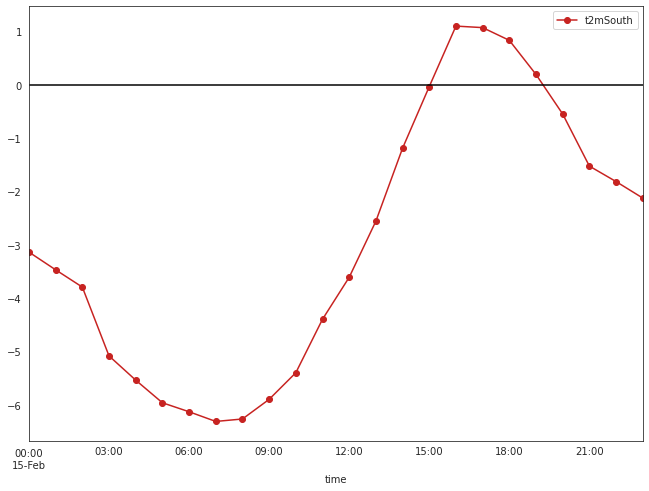

In [17]:
temperature_fname='tempWP_NSsplit.csv'
temperature = pd.read_csv(INTERIM_DIR / 'temperatures' / temperature_fname, parse_dates=[0])

temperature = temperature.set_index('time')

temperature['2021-02-15':'2021-02-15'].t2mSouth.plot(marker='o', legend=True)
plt.axhline(0, color='k')
(temperature['2021-02-15':'2021-02-15'].t2mSouth > 0).sum()

# Gas

Fit results:
Recovery rate: k = -0.11303779721762533
Outage start: 2021-02-10 02:00:00-06:00 + 120h
Outage length: 60h
Recovery length: 145.36888313293457h
Outage capacity: 18.113178333333334 GW
Outage capacity before: 0.14300000000000002 GW
Outage capacity after: 1.6810000000000003 GW


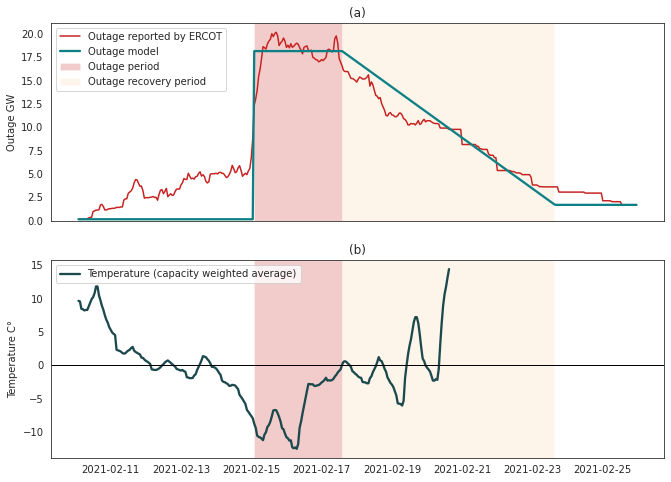

In [19]:
fit_and_plot(
    generator_type='gas',
    outage=data.NG * 1e-3,
    temperature_fname='temppowerplant.csv',
    temperature_column_name='NG',
    temperature_index_name='Unnamed: 0',
)

# Gas (gas field temperature)

Fit results:
Recovery rate: k = -0.1122128386080531
Outage start: 2021-02-10 02:00:00-06:00 + 120h
Outage length: 59h
Recovery length: 146.64688911437992h
Outage capacity: 18.136663700564974 GW
Outage capacity before: 0.14300000000000002 GW
Outage capacity after: 1.6810000000000003 GW


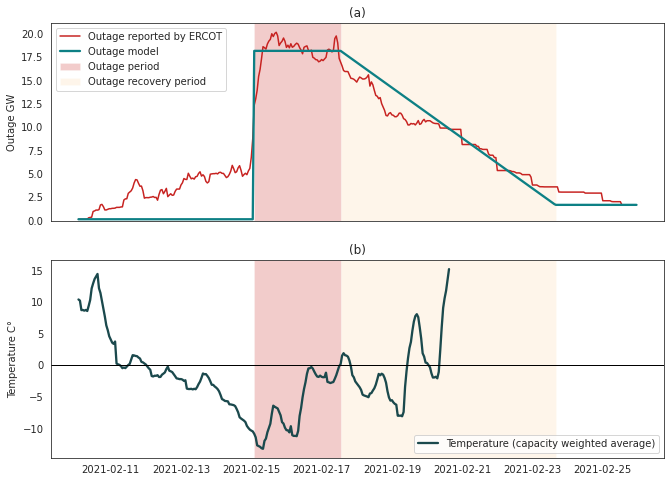

In [20]:
fit_and_plot(
    generator_type='gas_gasfield_temperatures',
    outage=data.NG * 1e-3,
    temperature_fname='temp_gasfields.csv'
)

# Wind (North)

Fit results:
Recovery rate: k = -0.31851913145465355
Outage start: 2021-02-10 00:00:00-06:00 + 8h
Outage length: 220h
Recovery length: 38.58420867919922h
Outage capacity: 12.884808636363637 GW
Outage capacity before: 0.232 GW
Outage capacity after: 0.595 GW


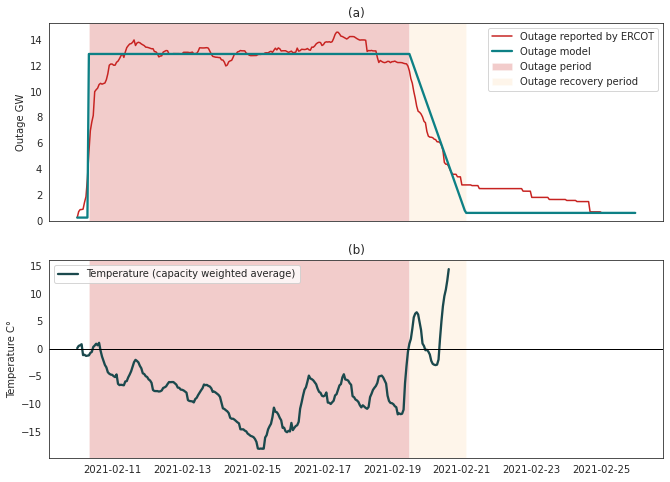

In [21]:
fit_and_plot(
    generator_type='wind_north',
    outage=data_north.WIND * 1e-3,
    temperature_fname='tempWP_NSsplit.csv',
    temperature_column_name='t2mNorth'
)

# Wind (South)

Fit results:
Recovery rate: k = -0.04273621681264756
Outage start: 2021-02-10 02:00:00-06:00 + 118h
Outage length: 16h
Recovery length: 100.52371139526369h
Outage capacity: 4.5540031249999995 GW
Outage capacity before: 0.02 GW
Outage capacity after: 0.258 GW


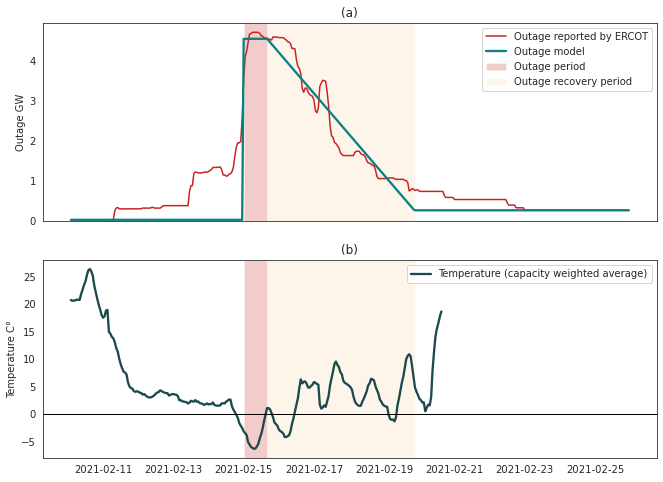

In [22]:
fit_and_plot(
    generator_type='wind_south',
    outage=data_south.WIND * 1e-3,
    temperature_fname='tempWP_NSsplit.csv',
    temperature_column_name='t2mSouth'
)

# Coal

Fit results:
Recovery rate: k = -0.06354331405869736
Outage start: 2021-02-10 07:00:00-06:00 + 115h
Outage length: 106h
Recovery length: 35.48374938964844h
Outage capacity: 3.218755031446541 GW
Outage capacity before: 0.022 GW
Outage capacity after: 0.9640000000000001 GW


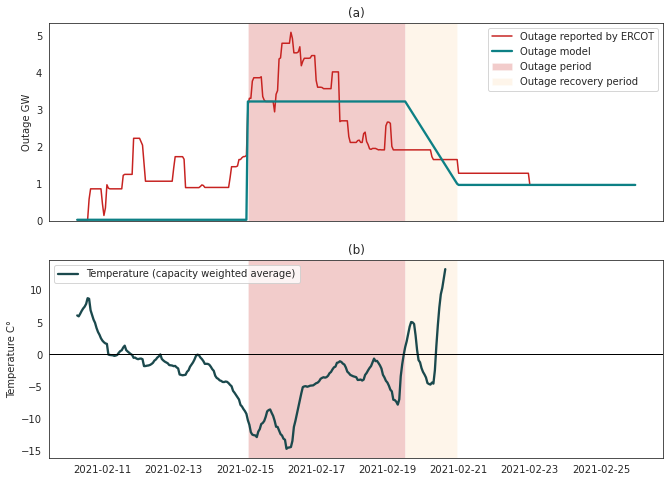

In [23]:
fit_and_plot(
    generator_type='coal',
    outage=data.COAL * 1e-3,
    temperature_fname='temppowerplant.csv',
    temperature_column_name='COAL',
    temperature_index_name='Unnamed: 0',
)

# Results

The parameters below are used for the outage function to simulate outages.

In [23]:
outage_function_parameters_all

,generator_type,outage_temperature_threshold,recovery_temperature_threshold,min_outage_length_h,outage_capacity,recovery_length
0,gas,-8.775861,0,10,18.113178,145.368883
1,gas_gasfield_temperatures,-10.879314,0,10,18.136664,146.646889
2,wind_north,-1.232821,0,10,12.884809,38.584209
3,wind_south,-3.136826,0,10,4.554003,100.523711
4,coal,-10.220208,0,10,3.218755,35.483749


In [24]:
outage_function_parameters_all.to_csv(
    DATA_DIR / 'output' / 'outage_function_parameters' / 'outage_function_parameters.cvs', index=False
)